<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [252]:
%%capture
pip install pyswarms

In [253]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [254]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [255]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [256]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [257]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [258]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [259]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [260]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [261]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [262]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [263]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [264]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


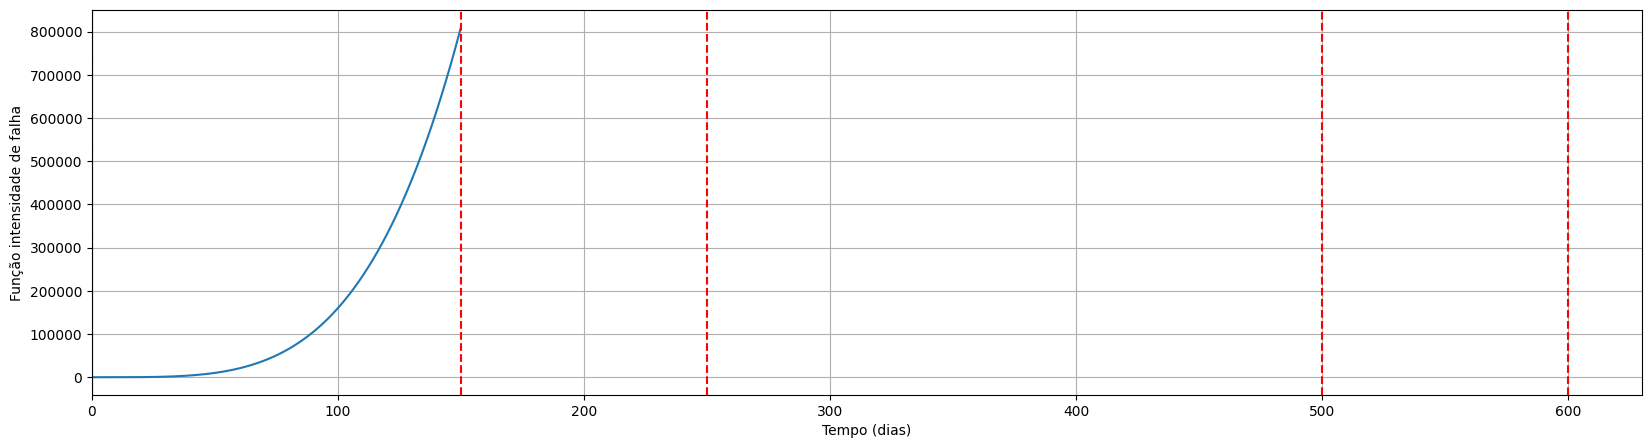

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [265]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [266]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = 730
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [267]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-08-31 22:10:00,537 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=8.2e+10<ipython-input-266-acae50a73c8b>:83: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=8.2e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 26, 60, 128, 176, 202, 335, 395, 440, 468, 587, 645]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 3802.0403200000005, 118410.38888679426, 4065172.5617235787, 6478750.9244651925, 8083907.91698838, 347801668.8599095, 404811499.4736404, 749498827.2908485, 756814265.0719165, 1378083901.8100271, 3440823483.362213, 3622233546.5792284]
Custo =  218073836888.36984


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 44, 88, 170, 240, 318, 349, 383, 442, 479, 503, 587, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25

pyswarms.single.global_best:  28%|██▊       |28/100, best_cost=5.2e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 17, 89, 183, 229, 330, 376, 423, 471, 505, 535, 577]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 454.35424000000006, 1291200.4845283101, 7413418.24607013, 8956775.324252909, 77402114.12747817, 84551057.81039973, 138298066.32183158, 221087856.0517133, 293527394.82467335, 372402361.5433305, 1336962300.7197852, 3279713729.289152]
Custo =  176964957295.52545


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 15, 86, 154, 189, 232, 387, 423, 517, 590, 649, 713]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.2

pyswarms.single.global_best:  47%|████▋     |47/100, best_cost=5.2e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 8, 61, 109, 123, 158, 188, 228, 240, 343, 392, 424, 499, 515, 597, 638, 711]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 10.48576, 216690.479723663, 500620.00638611545, 524341.9149378674, 1528647.6248892809, 3017106.767946059, 24590737.796328396, 25854722.008211963, 55804509.52269684, 64940120.38266834, 99343511.85912862, 280189413.6685206, 314789644.8699511, 2415535842.621615, 2636812623.048913, 6448608048.73184, 6473063727.545498]
Custo =  365

pyswarms.single.global_best:  66%|██████▌   |66/100, best_cost=5.2e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 9, 59, 82, 106, 155, 191, 237, 296, 330, 401, 421, 522, 651, 676, 704]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 18.895680000000002, 176768.4943488426, 196437.76299893318, 239100.86111730748, 884444.1347378932, 2920297.346806908, 31780085.01382626, 51532745.89371216, 54338036.239281036, 420611774.8041628, 440471671.3257629, 762956669.7014214, 1770576682.3235888, 1932654090.3376637, 2147185015.9934235, 3709081091.2220364]
Custo =  369976512629.0751


Número de ciclos de

pyswarms.single.global_best:  85%|████████▌ |85/100, best_cost=5.2e+10

Custo =  126149136479.10834


Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 8, 58, 74, 107, 153, 192, 238, 327, 333, 400, 421, 466, 522, 659, 694]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 10.48576, 166438.75986726093, 172820.28131087628, 267638.33860030596, 798192.3445910646, 3130956.0010489225, 32485001.875561904, 85736162.94078572, 86056823.34602542, 429013633.2029147, 449953428.0272818, 523523596.7126341, 670860280.6929348, 1821386696.4753103, 2079346341.9239943, 2131881717.7607362]
Custo =  115908978820.14859



pyswarms.single.global_best: 100%|██████████|100/100, best_cost=5.2e+10
2023-08-31 22:10:01,726 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16963677 6.05198264 4.993834   3.43995448 3.30043197 0.9005235
 3.16854532 6.16816883 5.48498755 0.71568761 1.80488832 3.6034979
 1.91676045 2.93780161 3.43975085 0.2186967  2.07643652 4.21493316
 2.08853805 3.46389475 4.96166098 0.86659053 3.94806712 3.70674858]
2023-08-31 22:10:01,728 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 13, 57, 71, 106, 120, 189, 342, 394, 438, 526, 655, 661]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 130355.35026414243, 134606.02121900863, 242997.67807932873, 264843.8608292023, 6145048.634204449, 180241517.54804555, 227037316.1155969, 283624015.14720464, 555974128.3313618, 1585581565.7489867, 1619597658.1237998, 2296148891.506421]
Custo =  119871187781.82526


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 9, 59, 69, 105, 192, 336, 399, 434, 633, 675, 713]
Severidade para cada subsistema: [0.75, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:01,746 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17120927 6.05827563 4.99464762 3.44599685 3.30236997 0.89925481
 3.16625514 6.16751714 5.49148691 0.71798097 1.80200835 3.5979968
 1.89899005 2.93630139 3.43828864 2.28349301 2.07838037 4.21702693
 2.09200207 3.46905594 4.97003518 0.86136896 3.95084732 3.71457765]
2023-08-31 22:10:01,748 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 9, 69, 108, 190, 340, 401, 422, 463, 535, 571, 686]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 18.895680000000002, 401761.9933515927, 553884.8574301238, 4853450.078394671, 168850450.14378807, 230443845.62303534, 251578912.0024106, 315864408.2013328, 537393769.658888, 1334336379.5357635, 2364808021.765144, 2768864462.313698]
Custo =  192393039133.69318


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:01,759 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17286822 6.05611943 4.99440183 3.45151264 3.29901057 0.89950395
 3.1727256  6.16780475 5.4897541  0.71731514 1.80482036 3.60465984
 1.9008958  2.93745055 3.43677582 2.56594574 2.08713629 4.21552393
 2.09554991 3.47124511 4.97241706 0.85979551 3.9518411  3.71506101]
2023-08-31 22:10:01,761 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 8, 66, 108, 191, 253, 271, 340, 406, 573]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 10.48576, 326832.78620576806, 514578.90930604213, 5020746.953463881, 17425781.367798395, 20600829.67000565, 31982504.117997013, 103696727.08950737, 1093942665.9538534, 3114426364.4623837]
Custo =  81965364585.84885


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:01,774 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17373907 6.0533386  4.99403108 3.45563576 3.29613468 0.89987925
 3.17849653 6.16807457 5.48816515 0.71662858 1.80736064 3.6103522
 1.90586005 2.938575   3.43548105 4.09264017 2.09360935 4.21414034
 2.09732254 3.47156171 4.97180512 0.85876959 3.95250098 3.71460387]
2023-08-31 22:10:01,775 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 7, 62, 108, 122, 189, 265, 280, 340, 408, 577, 645, 670, 717]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 5.378240000000001, 242520.07846401245, 487768.18702259345, 510851.7543039253, 6062247.833842377, 26430462.39082064, 29376125.715673022, 37890392.44763897, 113960668.41660501, 1148224736.912085, 1563684206.6689308, 1720170601.3415618, 1790016640.5154755, 1901126859.7071369]
Custo =  121365196148.8625


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:01,789 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17381711 6.05073821 4.99364687 3.45521186 3.29425203 0.90025501
 3.18174336 6.16834019 5.48625596 0.71579294 1.80940583 3.61441632
 1.91061426 2.93935652 3.43435793 6.85884341 2.09631631 4.2131257
 2.09667403 3.4710507  4.96846835 0.85803334 3.9521536  3.71232799]
2023-08-31 22:10:01,791 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 108, 131, 188, 274, 329, 342, 370, 410, 507, 582, 693]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1.0, 4353817.386003031, 4425376.051076827, 8463811.826455584, 36735900.87043573, 62780666.88505268, 68311564.9732585, 176881806.43414876, 216147392.15726668, 490341493.9497465, 809521587.948829, 5937987325.964326, 6271976469.109144]
Custo =  274058904562.81677


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:01,803 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.1735188  6.04853054 4.99332507 3.45101199 3.29402671 0.90061829
 3.18155731 6.16853359 5.48424812 0.71502281 1.81067527 3.61554737
 1.91617864 2.93987042 3.43475476 3.63602434 2.09321338 4.21258373
 2.09525859 3.46931576 4.96408175 0.85936462 3.95135375 3.70933707]
2023-08-31 22:10:01,805 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 4, 107, 138, 185, 321, 345, 382, 410, 503, 587]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 4218327.897174497, 4375073.680694343, 7125537.702307858, 119876145.3486121, 131061052.32340872, 292450805.24846315, 318416848.42520815, 384747438.2256163, 766410270.9503282, 8839487309.975658]
Custo =  273603137236.2345


pyswarms.single.global_best:   0%|          |0/1, best_cost=5.2e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 2, 106, 144, 183, 286, 315, 348, 410, 426, 500, 591, 642, 666, 703]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.01024, 4150780.273899781, 4433433.980901319, 6406086.873304273, 51830840.2783223, 61640825.489009276, 160870822.74886, 512701073.0275179, 529075831.5292472, 708017585.531409, 1143371137.9888673, 2932527707.6751747, 3078885215.2642503, 3367127293.1294074, 3403972684.65293]
Custo =  272476945659.90784


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,031 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17252589 6.04723209 4.99314479 3.44424168 3.29526679 0.90093755
 3.17880393 6.1686771  5.48251779 0.7143628  1.81140786 3.61505433
 1.92120831 2.93997468 3.43511877 0.53172442 2.08806027 4.21268979
 2.09382058 3.46622487 4.95983034 0.8618406  3.94970534 3.70656221]
2023-08-31 22:10:02,033 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,131 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17108735 6.04663788 4.993109   3.43800786 3.29752476 0.9011942
 3.17405074 6.16880035 5.48139677 0.7139477  1.81029387 3.61231247
 1.92472456 2.93971789 3.43681583 5.36736613 2.0818972  4.21307156
 2.09160288 3.46276



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 1, 104, 146, 181, 311, 350, 378, 410, 432, 500, 569, 594, 600, 673]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 0.00032, 3831970.655758956, 4207017.913485101, 5821998.274186486, 99357052.3111277, 120275010.87815717, 238639116.05879718, 268867320.8914537, 429500958.9145154, 589613274.8564831, 853544267.3139665, 1509368611.8908303, 1676590318.2846043, 2208568006.116743, 2306242035.380125]
Custo =  332421882338.853


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,168 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16962571 6.04741367 4.99323658 3.4324567  3.29997627 0.90135387
 3.16960003 6.16883094 5.48053003 0.71390667 1.80872271 3.60907099
 1.92720264 2.93945098 3.43910138 2.97339005 2.07522454 4.21380332
 2.0892435  3.45976511 4.95468051 0.86751603 3.94624068 3.7024865 ]
2023-08-31 22:10:02,170 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 1, 59, 103, 147, 180, 307, 352, 409, 438, 502, 568, 594, 600, 679]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 0.00032, 222455.04801605057, 417667.4621174718, 847088.7836496612, 2301223.0231746603, 88070782.11160983, 113639157.3155536, 435113853.65655005, 470005830.076802, 620315098.1017047, 868321836.8115096, 1549703411.1732898, 1716925117.5670638, 2323340371.520941, 2406772777.670942]
Custo =  310577263600.7748


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,293 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16831178 6.04918563 4.99351903 3.42952392 3.30230582 0.90132811
 3.16530304 6.16882233 5.47975454 0.71395283 1.80717414 3.60474509
 1.92801479 2.93888498 3.44133369 0.76014398 2.06928382 4.21469046
 2.08705505 3.45721871 4.95448928 0.87016018 3.94495719 3.70190979]
2023-08-31 22:10:02,304 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 2, 58, 102, 146, 262, 304, 353, 405, 442, 506, 568, 594, 600, 678, 715]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 0.01024, 198363.91949739348, 389804.024488881, 812184.1879698585, 45718884.62645333, 59297025.982525036, 65802980.33158961, 348817991.4057474, 396545811.0054931, 551366538.8288493, 780935248.7570128, 1462316823.118793, 1629538529.512567, 2223126656.8824215, 2273487729.6143675, 2292247216.222842]
Custo =  312056530339.25964


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 3, 57, 100, 142, 252, 303, 352, 397, 444, 463, 593, 600, 652, 669]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 0.07776000000000001, 176406.7629711179, 348148.04406275065, 698460.6111587607, 36542670.25262347, 53963336.588990256, 60410538.01593136, 287817051.29655135, 352351956.9318256, 379645018.14268166, 1115631882.0524807, 1142679258.8435287, 1457849466.6075253, 1473233686.2316515, 2058530568.9966898]
Custo =  139055816610.39584



2023-08-31 22:10:02,372 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16747574 6.05151131 4.99379469 3.42954736 3.30425527 0.90117111
 3.16235261 6.16867938 5.48031764 0.71399536 1.80558509 3.60051005
 1.92570312 2.93815978 3.44307083 6.38802539 2.06559849 4.21552912
 2.08552936 3.4550537  4.9561009  0.87148129 3.94421132 3.70222293]
2023-08-31 22:10:02,374 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,473 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16711258 6.05370333 4.99404311 3.42965822 3.30571214 0.90098676
 3.15991788 6.16841078 5.48193558 0.71413889 1.80410699 3.59721048
 1.92171287 2.93741045 3.44399968 5.54194108 2.06265961 4.21620892
 2.08422287 3.45570658 4.95800786 0.8716599  3.94412647 3.70376488]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 57, 100, 137, 180, 244, 304, 351, 360, 445, 590, 600]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 0.32768, 171276.09600639858, 343017.37709803134, 576156.7032796557, 2746526.3423161777, 14320577.638963684, 36564102.06157212, 42493923.792288125, 74683173.16478221, 217175455.84555477, 492509540.7786917, 531445821.43757176, 2062028166.2188256]
Custo =  94243582789.22217


2023-08-31 22:10:02,476 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,502 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16695777 6.05540323 4.99421134 3.43239934 3.30626792 0.90074068
 3.15824351 6.16816107 5.48373413 0.71441181 1.80301093 3.59548825
 1.91777899 2.93684056 3.44373247 4.89848136 2.06306582 4.2167055
 2.0835959  3.45855893 4.96028042 0.87080247 3.94462854 3.70523081]
2023-08-31 22:10:02,503 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 57, 62, 99, 131, 181, 285, 306, 349, 445, 536, 587]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 166265.8824671869, 166718.2145156839, 275179.7200294026, 421656.36399706017, 3259497.169158231, 49064812.26152795, 55111096.24857064, 78486828.04966749, 824835751.5184287, 1130253883.684908, 1336174114.7371838, 3092643134.4156237]
Custo =  115163574716.57832


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,528 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16741802 6.05676125 4.99432399 3.43527226 3.30614774 0.90051546
 3.1581224  6.16793713 5.48559487 0.71477613 1.80251608 3.59454973
 1.91416697 2.93632994 3.44267141 4.48468874 2.06590102 4.21669247
 2.08381994 3.46236743 4.96251363 0.86962181 3.94563813 3.70695922]
2023-08-31 22:10:02,530 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 6, 57, 64, 100, 125, 183, 308, 348, 443, 533, 585, 657, 678, 706]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2.4883200000000003, 161374.3422459376, 162221.76726243846, 264866.64216714364, 338963.81314350246, 4163632.918953596, 87917626.40305758, 109040640.96555023, 834530462.9065727, 1129256005.787562, 1337187417.9824417, 1814841130.820563, 1951236864.3584805, 3419166226.869711, 3629315151.4890437]
Custo =  361978657097.883


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,548 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16817801 6.05748586 4.99441796 3.43921062 3.30466258 0.90031287
 3.16108902 6.16776818 5.48726397 0.71530266 1.80225966 3.59487081
 1.91147457 2.93612387 3.44139438 4.31551932 2.07101394 4.21637055
 2.08525734 3.46603191 4.96428335 0.86824594 3.94710297 3.70850064]
2023-08-31 22:10:02,549 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 6, 57, 64, 101, 121, 185, 314, 346, 384, 440, 457, 534, 582, 663]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2.4883200000000003, 161374.3422459376, 162221.76726243846, 275507.7359103074, 318207.12253794976, 5076958.495504386, 99695812.44825737, 115466396.99783252, 284561100.4010847, 362147566.3224297, 518853083.7976756, 759046788.1760719, 793116043.8382162, 1365346909.5643451, 2018703024.8959055]
Custo =  148031166666.23685


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,561 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.1691823  6.0575083  4.99448114 3.44297755 3.30208627 0.90017497
 3.16388386 6.16765116 5.4886416  0.71585083 1.80203829 3.59578412
 1.90971191 2.93634618 3.44018975 3.92616579 2.07611861 4.21608059
 2.08715416 3.46887223 4.96517234 0.86685589 3.94857973 3.70986982]
2023-08-31 22:10:02,563 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 6, 58, 64, 102, 187, 240, 277, 321, 345, 437, 534, 580]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2.4883200000000003, 176581.50980454008, 177245.58185943274, 302035.85130738816, 4949764.387820105, 13032423.639062043, 21195421.347645603, 25150281.35287789, 95713947.86510558, 761306555.8714132, 1091073272.647506, 1265514686.4974713, 3151190945.1288776]
Custo =  121849482340.44601


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,578 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17015974 6.05596761 4.99441456 3.44628238 3.29974636 0.90014777
 3.16743242 6.1675507  5.48959513 0.7162969  1.80243163 3.59700199
 1.90953973 2.93685568 3.43909584 3.69736482 2.08078781 4.2155755
 2.08918784 3.47042515 4.96561319 0.86553398 3.94979055 3.71053813]
2023-08-31 22:10:02,579 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 7, 59, 62, 103, 120, 188, 243, 276, 327, 344, 433, 537, 578, 647]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 5.378240000000001, 187403.9984015626, 187630.63744330313, 346104.7259766047, 376748.96195758035, 5999325.777108793, 14935345.18117024, 21897948.356794603, 27402536.50161424, 28626553.582514875, 649666974.182609, 1021738208.6737278, 1172661085.7771347, 1600557592.7472506, 2447032582.024302]
Custo =  125127834005.46025


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,591 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17093963 6.05347182 4.99434969 3.44870366 3.29783632 0.9002101
 3.17082303 6.16758541 5.48977136 0.71664903 1.80303404 3.59964791
 1.91064601 2.93744004 3.43829941 3.84340618 2.08449426 4.21508772
 2.09089573 3.46994275 4.96509202 0.86449335 3.9506807  3.7107932 ]
2023-08-31 22:10:02,592 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 7, 60, 104, 122, 188, 247, 344, 430, 578]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 5.378240000000001, 204525.22205721482, 403568.74094870617, 439428.0476701253, 5744568.3156442465, 16302783.66441692, 89205283.51193, 124899170.13465594, 954378092.4104834, 2877989039.9708614]
Custo =  78784999057.60872


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,606 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.1714478  6.05082645 4.99415909 3.45032442 3.2962809  0.90035291
 3.17383824 6.16773013 5.48944234 0.71683536 1.80367748 3.60262813
 1.91230145 2.93806264 3.43762443 3.70328924 2.08728664 4.21464305
 2.09200255 3.46933027 4.96424699 0.86383828 3.95144309 3.71102217]
2023-08-31 22:10:02,608 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 6, 105, 123, 188, 252, 345, 428, 474, 579, 652, 663]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 2.4883200000000003, 3713628.304091349, 3750422.484574746, 8901987.368387556, 21793640.504126795, 90278976.82534379, 122947301.95249027, 203529082.98985186, 696549820.2380629, 1168591620.7773747, 1232439362.3717253, 1356553728.044749]
Custo =  88082288983.68698


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,622 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17183258 6.04875808 4.99396524 3.44939467 3.29593326 0.90048884
 3.17589748 6.16788796 5.48861042 0.71680772 1.80448755 3.60548125
 1.91405724 2.93862171 3.437042   4.21340469 2.08655527 4.21424994
 2.09249009 3.46865547 4.96304814 0.86404784 3.9511247  3.70997483]
2023-08-31 22:10:02,624 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 106, 125, 187, 257, 346, 364, 426, 463, 581, 676]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3959548.2535257754, 4002348.3697936805, 8635118.488117207, 24623505.71551227, 88865775.32780324, 90490796.4359496, 169057582.2164224, 179424379.20799455, 771203215.7760369, 942537070.9120457, 1451206872.4906468]
Custo =  75769909443.49297


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,637 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17152274 6.0473695  4.99376033 3.44781545 3.296969   0.90061769
 3.1759268  6.16809395 5.48735164 0.71660694 1.80531993 3.60786974
 1.91608687 2.93897785 3.43697797 4.28919756 2.08540296 4.21389691
 2.09237289 3.46696492 4.96160081 0.86452112 3.95059809 3.70867271]
2023-08-31 22:10:02,639 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 105, 127, 187, 260, 348, 389, 425, 508, 583, 689]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3773428.320457337, 3833085.0468967278, 8191741.01258826, 26040030.704596892, 90326284.82531337, 96947441.27277324, 136719906.698628, 358188916.7764164, 679414655.6480184, 5473033490.042788, 5846754884.063896]
Custo =  254574730486.5252


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,658 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.1708553  6.04724108 4.99359059 3.44489761 3.29858192 0.90071387
 3.1740304  6.16829118 5.48556562 0.71632056 1.8060277  3.60878011
 1.91804387 2.93920977 3.43733171 4.13325876 2.08223792 4.21385654
 2.0913121  3.46535864 4.96031242 0.86525369 3.94951939 3.70746317]
2023-08-31 22:10:02,659 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 105, 130, 185, 264, 349, 394, 424, 508, 585, 648, 707]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3833996.9675222635, 3916981.865006711, 7515075.171131597, 29056254.67050742, 90403376.99837509, 98449366.97611052, 130416085.01403269, 355572033.46115255, 692080854.3658873, 2967135512.294153, 3465091775.2879896, 4850259779.178163]
Custo =  456690981393.80225


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,675 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16994267 6.04852472 4.99344743 3.4408868  3.3002265  0.90078889
 3.17123315 6.16845787 5.48379285 0.71605688 1.80657217 3.60885226
 1.91942767 2.93916786 3.43766838 3.58242035 2.07799895 4.21389916
 2.09022922 3.46372596 4.95953286 0.86613004 3.94842908 3.70630184]
2023-08-31 22:10:02,677 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 3, 104, 132, 184, 266, 297, 329, 350, 375, 397, 425, 508, 586, 641, 696]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.07776000000000001, 3711651.2422036882, 3822148.8047722415, 7026365.408124369, 30621410.58591003, 39117748.60897623, 41641310.25006841, 43359232.100230776, 146116712.25472263, 163634301.30659193, 353585060.2569355, 575054070.334724, 919380169.8734113, 2831017518.139248, 3263271795.20018, 3567980854.4950023]
Custo =  284705173276.9667


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,692 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16903802 6.04977083 4.99340965 3.43706558 3.301737   0.90082107
 3.16847097 6.16858425 5.48227561 0.71572471 1.80672575 3.6084117
 1.92016599 2.9391282  3.43840752 2.85829749 2.0737259  4.21406107
 2.08915223 3.46227616 4.95937249 0.86693417 3.94742111 3.70533166]
2023-08-31 22:10:02,693 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 3, 103, 133, 183, 266, 276, 326, 350, 398, 427, 470, 508, 587, 631, 690]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.07776000000000001, 3534957.222401649, 3666506.0492441272, 6608889.358490098, 30728260.56660923, 32527485.88308061, 37779545.42370114, 112562105.3205678, 356899631.61390096, 388516343.92509943, 460526170.8047606, 544602537.0884124, 622873062.7118638, 2070399724.3842332, 2523979134.5063853, 2584141131.623158]
Custo =  227755191309.68652


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,705 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16839658 6.05102945 4.99347689 3.43410302 3.30282964 0.90082933
 3.1660043  6.16868514 5.48165703 0.71541657 1.80641522 3.60682832
 1.92023955 2.9390295  3.4393411  2.15640579 2.07028471 4.21442275
 2.08805095 3.46099805 4.95924866 0.86757895 3.94653831 3.70487605]
2023-08-31 22:10:02,706 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 3, 102, 134, 182, 264, 297, 323, 351, 396, 430, 588]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.07776000000000001, 3365057.449832059, 3520660.651898431, 6217617.451979874, 29251576.88461814, 38422957.278651446, 40154108.51649543, 54408627.26701343, 279507119.3644073, 318441338.6148347, 1298039524.4609213, 3036493932.1906176]
Custo =  103277896848.60646


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,719 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16811962 6.05218111 4.99363985 3.43253152 3.30379207 0.90077733
 3.1640953  6.1687156  5.48128689 0.71516947 1.80602296 3.60476616
 1.91944403 2.93888112 3.44022651 1.98333844 2.06849925 4.21481345
 2.08718582 3.46017607 4.95969425 0.86808186 3.94576551 3.70466991]
2023-08-31 22:10:02,721 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 3, 101, 134, 182, 260, 320, 350, 361, 393, 433, 588, 690]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.07776000000000001, 3201754.0737743764, 3368949.177744978, 6065905.977826421, 26114021.04435431, 52785458.555777356, 55622228.47720882, 95266824.83861455, 120951437.54671165, 130154897.70488714, 1078666841.1331043, 1972851302.2680607, 2336564044.608406]
Custo =  118022341317.65076


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,733 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16792275 6.05317956 4.99383375 3.43232019 3.30452849 0.9006716
 3.16247632 6.16862427 5.48178028 0.71508917 1.80551052 3.60280712
 1.91802015 2.93847563 3.44097468 2.48859325 2.06849517 4.21516508
 2.08665641 3.45970248 4.96021182 0.86846993 3.94517981 3.70463214]
2023-08-31 22:10:02,735 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 4, 60, 101, 134, 182, 255, 318, 350, 378, 435, 466, 587, 648, 699]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 222663.19163539776, 374810.80974680756, 542005.9137174094, 3238962.7137988526, 19990550.073908705, 48005291.79012182, 51131400.594950266, 169495505.7755903, 245555685.21116763, 293373412.4710001, 930333961.1286976, 1301403489.5155587, 1704489901.113415, 3559122452.2268667]
Custo =  348090903252.335


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,749 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16790202 6.0537878  4.99400832 3.43250942 3.30439205 0.90054045
 3.16246994 6.16844237 5.48261626 0.71504167 1.80486416 3.60120939
 1.9164195  2.93793267 3.4413901  3.32948017 2.06939444 4.21541676
 2.08655364 3.46036578 4.96086078 0.8686536  3.94506094 3.70497882]
2023-08-31 22:10:02,750 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 61, 101, 133, 182, 250, 318, 349, 437, 585, 652, 708]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 242293.15094661168, 383859.07898920804, 536372.233352049, 3328574.0443773717, 17222521.528427742, 48639753.22202343, 51589550.816186726, 689040241.7579281, 1552682130.212162, 1977762617.3849463, 2449088992.764217, 2640859361.2902017]
Custo =  149552298676.60376


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,762 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16838449 6.05381994 4.99412567 3.43306898 3.30316585 0.90042136
 3.16288208 6.16827055 5.48377339 0.71512021 1.80428886 3.6003422
 1.91505161 2.93741175 3.44161237 4.54703894 2.07226397 4.21560131
 2.08666801 3.46189526 4.96156059 0.86873656 3.94585417 3.70570744]
2023-08-31 22:10:02,764 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 61, 101, 133, 183, 246, 318, 348, 439, 584, 644, 686, 717]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 242293.15094661168, 383859.07898920804, 536372.233352049, 3478755.5425980203, 15065459.709635636, 49380228.034985326, 52160497.56887168, 722932712.3355565, 1553333941.3258722, 1908702787.4962819, 2210000401.6709385, 2250725634.0875497, 2361835853.279211]
Custo =  147519370586.7003


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,778 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16902858 6.05336288 4.99419553 3.4343661  3.30159532 0.90032506
 3.16410956 6.16808858 5.48516472 0.71524438 1.80380228 3.60029959
 1.91384311 2.9369751  3.44177679 5.70884636 2.0760325  4.21557606
 2.0871002  3.46327624 4.96219427 0.86862711 3.94685942 3.7065253 ]
2023-08-31 22:10:02,779 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 61, 102, 131, 183, 245, 320, 347, 439, 539, 583, 675]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 235675.11946508172, 390960.42625646794, 507881.4635955688, 3655570.098950671, 14787783.341570888, 52174836.86135568, 54533276.71478547, 732476077.3765296, 1088611831.8858733, 1257700595.3342197, 1977681886.2345333, 2497121571.0033736]
Custo =  131525702859.26584


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,791 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16964256 6.0529201  4.99416326 3.43640425 3.2999838  0.9002583
 3.16570601 6.16792987 5.48636397 0.71540608 1.80336575 3.60036489
 1.91362847 2.93677569 3.44181856 6.10963795 2.07948587 4.21539412
 2.08767745 3.46454974 4.96269463 0.86818692 3.94798789 3.70728544]
2023-08-31 22:10:02,792 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 61, 103, 129, 184, 244, 322, 346, 375, 437, 538, 582, 637, 667]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1.0, 235675.11946508172, 405722.3426096116, 493900.49750560196, 4029697.5660830247, 14437491.757048106, 55095873.41058546, 57071801.61337927, 175624393.5087424, 261919245.2753574, 357735345.0294069, 525708442.5495478, 833343730.1275814, 1020212546.9244561, 4702696712.368414]
Custo =  325494274269.1493


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,805 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17019386 6.05252029 4.99412886 3.43896261 3.29861396 0.900203
 3.16737156 6.16785257 5.4871663  0.71562749 1.80299405 3.60125035
 1.91363031 2.93672192 3.4415333  6.93562538 2.08200909 4.21520627
 2.08827542 3.46554614 4.96300998 0.86760894 3.94900965 3.70786248]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 60, 103, 128, 185, 246, 323, 345, 379, 436, 539, 581, 634, 663]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 216478.89678734273, 398762.8050123333, 478098.9900586884, 4313910.040633008, 15303637.560449239, 55550495.138932735, 57285641.61518288, 201449312.69307715, 278161193.2625291, 649877170.9688411, 808119157.0178472, 1097464888.4611368, 1273434582.1420507, 1926790697.4736114]
Custo =  140406833507.22925


2023-08-31 22:10:02,807 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,819 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17067327 6.05203703 4.9940358  3.44147803 3.29786702 0.90024315
 3.16916782 6.16782568 5.48730899 0.71584071 1.80320108 3.6022055
 1.91427945 2.93687943 3.44092959 6.60981382 2.08409688 4.21502
 2.08883465 3.46636362 4.9629777  0.86686111 3.94988157 3.70824175]
2023-08-31 22:10:02,823 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 6, 104, 126, 186, 249, 325, 345, 387, 434, 455, 581, 637, 666]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 2.4883200000000003, 3536858.707770356, 3595115.291441756, 7880704.63685493, 19947978.70768518, 60204152.25406698, 61731439.7356205, 253758568.28883997, 312970598.6850967, 502175558.758739, 1155698192.124659, 1469895235.3576279, 1649010862.3780954, 1764820025.5090594]
Custo =  138130776620.15408


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,840 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17083946 6.05158819 4.99389627 3.44336754 3.29762595 0.90031427
 3.17077191 6.16785853 5.48683709 0.71602411 1.80369566 3.60327136
 1.91546534 2.93715705 3.44038109 5.92809744 2.08536926 4.21485148
 2.08928103 3.46670285 4.96256801 0.86611004 3.95060678 3.70818933]
2023-08-31 22:10:02,842 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 6, 104, 126, 186, 252, 326, 345, 432, 461, 581, 672, 717]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2.4883200000000003, 3536858.707770356, 3595115.291441756, 7880704.63685493, 21446924.8725868, 60456109.059516765, 61883912.486059204, 663738237.8322684, 706296912.8934047, 1313160908.1791773, 2011391088.2922633, 2397722382.6460743, 2508832601.8377357]
Custo =  156662235370.11746


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,859 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17079605 6.05129884 4.99375878 3.44459488 3.29804583 0.90041459
 3.1717618  6.16790362 5.48638921 0.71609377 1.80429499 3.6042504
 1.91683788 2.93756724 3.439731   5.67170856 2.08516427 4.2147186
 2.08953424 3.46646621 4.96212609 0.865516   3.95120783 3.70813314]
2023-08-31 22:10:02,863 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 6, 104, 126, 186, 255, 273, 326, 346, 430, 476, 582, 681, 711]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2.4883200000000003, 3536858.707770356, 3595115.291441756, 7880704.63685493, 23085822.14522162, 26352695.043826286, 32222577.698715217, 41450168.26164311, 612407394.9716744, 694290504.3046304, 1203343524.8508346, 2022321267.1867387, 2262443734.57311, 2426962586.5183554]
Custo =  157596764889.62604


pyswarms.single.global_best:   0%|          |0/1, best_cost=5.2e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 104, 127, 186, 258, 327, 347, 361, 391, 429, 582, 643, 706]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3594374.0341038606, 3659614.5363941607, 7814577.698802759, 24808122.589075774, 60206404.13801729, 61766520.238605514, 111967676.83575115, 135348273.85558465, 143592113.18592453, 1040579734.2194723, 1400856517.3510575, 1935605334.30522, 1967642112.0605862]
Custo =  108441960295.45592


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,877 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17046091 6.05107811 4.99365357 3.44516195 3.29853858 0.90051933
 3.17261787 6.16794475 5.48565039 0.71614842 1.80499889 3.60493403
 1.91805259 2.93794088 3.43914961 4.79653133 2.08285974 4.21465817
 2.08950219 3.46569808 4.96159082 0.864996   3.9508551  3.70802589]
2023-08-31 22:10:02,879 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,895 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16999766 6.05093804 4.99361256 3.44479864 3.2990519  0.90061389
 3.1729857  6.1680328  5.484816   0.71610353 1.80561981 3.60533316
 1.91896489 2.93823603 3.4387959  3.49285768 2.07911169 4.21462989
 2.0892302  3.4646



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 186, 260, 326, 348, 369, 392, 430, 583, 636, 702]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7528788.9255347885, 25802614.604748417, 58559986.92112626, 60350770.67908065, 141699481.0933498, 159210397.07033545, 203520997.80614775, 1105648451.7971232, 1398512600.5307708, 1951371885.9278886, 3630629001.375937]
Custo =  346021914733.6705


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:02,913 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16952779 6.05089794 4.99359483 3.44302918 3.29968418 0.90068074
 3.17237441 6.16813567 5.48409511 0.71605084 1.80604577 3.60514404
 1.91941425 2.93849108 3.4386754  2.24335865 2.07561989 4.21465624
 2.08895442 3.46374135 4.96076321 0.86533079 3.94942321 3.70748346]
2023-08-31 22:10:02,915 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 103, 129, 186, 262, 325, 349, 372, 392, 431, 466, 584, 700]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3510360.438289275, 7412815.685096299, 27040890.640421256, 57292928.61915974, 59331443.351009026, 151114691.59816873, 166134708.52297318, 442598715.1638879, 497464090.93299603, 1100034873.7229514, 1378108706.288899, 1644445509.7504294]
Custo =  122839055042.30765


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 4, 103, 130, 185, 264, 324, 350, 392, 432, 584, 698]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,010 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16910999 6.05094926 4.99364443 3.44115084 3.30032851 0.90071903
 3.17146578 6.16823779 5.48370107 0.71590991 1.8062915  3.60485966
 1.91967294 2.93865955 3.43865259 1.44812879 2.07269678 4.21468173
 2.08859351 3.46290543 4.96049457 0.8657171  3.9483027  3.70714907]
2023-08-31 22:10:03,012 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3478203.9246740816, 3575976.349008088, 7174069.655132974, 28715249.1545088, 56591714.29907949, 58896009.55386388, 261155823.98703873, 309071884.1741385, 1206497313.0637147, 2290535529.8703403, 2575964618.067435]
Custo =  125106301537.95923


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,026 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16880582 6.05113176 4.9936936  3.43920596 3.30091355 0.90075248
 3.17028814 6.16832958 5.48361288 0.71572771 1.80624943 3.60431258
 1.91935339 2.93875407 3.43876575 1.39083064 2.07023259 4.21471433
 2.08826331 3.46224134 4.96059621 0.86612959 3.94727444 3.70682651]
2023-08-31 22:10:03,027 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 102, 130, 185, 264, 291, 323, 350, 391, 433, 584, 698]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3310500.522676374, 3416373.335229797, 7014466.641354683, 28555646.140730508, 35217379.51751345, 37586228.271809116, 40018096.556818776, 235640600.1806799, 286870542.26941866, 1174504831.3955815, 2258543048.202207, 2543972136.3993015]
Custo =  124338650597.08072


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,039 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.168648   6.05154062 4.9937682  3.43753379 3.30137827 0.90077356
 3.16881488 6.16837707 5.4837486  0.71556042 1.80613282 3.60361876
 1.91868932 2.93883581 3.43913348 1.91472693 2.06874161 4.21476468
 2.08803379 3.46206231 4.96084326 0.86650764 3.94647519 3.70652073]
2023-08-31 22:10:03,041 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 4, 102, 130, 184, 261, 283, 323, 350, 378, 390, 434, 477, 585, 701]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3310500.522676374, 3416373.335229797, 6839055.8470022585, 26677011.349862605, 31391526.253013913, 34806267.50289796, 118571709.21463166, 236935814.3952717, 245465968.2148202, 564604145.6150465, 640797342.8460467, 1173355097.8376179, 6777003854.133358, 7033863731.96011]
Custo =  319278101597.3852


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16854957 6.05193156 4.99385203 3.436611   3.30171931 0.90074001
 3.16746766 6.16839652 5.48412346 0.71541431 1.80600291 3.60299258
 1.91802848 2.93884873 3.43961187 2.69877806 2.06964391 4.21485717
 2.08796762 3.46195443 4.96118757 0.86684952 3.94605732 3.70630343]
2023-08-31 22:10:03,055 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 60, 102, 130, 184, 258, 322, 349, 435, 467, 584, 704]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 222663.19163539776, 389335.124596177, 495207.93714959983, 3917890.4489220614, 21737548.90952632, 51702686.40724395, 54109889.30338029, 666093472.0237981, 716064233.7287078, 1311057887.5538025, 2511526265.630846, 2740226676.331016]
Custo =  133745760296.48471


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.1686758  6.05229403 4.99392214 3.43633402 3.30193747 0.90068397
 3.16656324 6.16837798 5.48449574 0.71530646 1.80579222 3.60245351
 1.9173498  2.93879105 3.44007615 3.59402624 2.070671   4.2149543
 2.08794979 3.46222581 4.96163105 0.86710251 3.94586017 3.70610897]
2023-08-31 22:10:03,077 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 3, 60, 102, 130, 183, 255, 321, 348, 435, 452, 584, 636, 683, 708]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.07776000000000001, 228988.4145985203, 395660.34755929955, 501533.16011272237, 3755561.903167902, 20110652.376262825, 51140790.81983945, 53523517.899361104, 672400874.9455656, 694453340.0898193, 1409356425.8163786, 1461777075.0332906, 1797758692.2990134, 3126808399.583154, 3318578768.109139]
Custo =  338883395329.54944


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,091 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16880955 6.05258062 4.99397926 3.43713795 3.30170058 0.90062018
 3.16616143 6.16835869 5.48497463 0.71521275 1.80557085 3.60203904
 1.9166028  2.93846351 3.44041813 4.18716944 2.07224558 4.21503541
 2.08804401 3.46257253 4.962035   0.86722435 3.94596754 3.70605675]
2023-08-31 22:10:03,092 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 4, 60, 102, 130, 183, 252, 282, 321, 347, 436, 584, 640, 677, 711]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 222663.19163539776, 389335.124596177, 495207.93714959983, 3749236.6802047794, 18372049.431977604, 25082543.50024963, 28286599.444438215, 40813100.22110656, 679370673.285662, 1538066976.8777184, 1857965188.847809, 2106767023.426446, 2151051762.2336497, 2315570614.178895]
Custo =  145790811716.34406


pyswarms.single.global_best:   0%|          |0/1, best_cost=5.2e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 60, 102, 130, 183, 249, 321, 346, 435, 584, 649, 674, 714]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 222663.19163539776, 389335.124596177, 495207.93714959983, 3749236.6802047794, 16785728.696564265, 52227207.508242026, 54319210.24029794, 686996710.3059131, 1555266926.170261, 1957974936.5445678, 2118172288.3315523, 4291332265.7605734, 4428968404.789123]
Custo =  357269128072.0687


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,113 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16910225 6.05269391 4.99399094 3.43819779 3.30140159 0.90053539
 3.16587751 6.16829337 5.48540801 0.7151445  1.80535524 3.60171195
 1.91596028 2.93801241 3.44061142 5.08635137 2.0745203  4.21510148
 2.0882392  3.46290977 4.96234064 0.86730595 3.9463634  3.70605988]
2023-08-31 22:10:03,120 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,135 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16937219 6.05276862 4.99396358 3.43934769 3.30101822 0.9004581
 3.16594943 6.16822949 5.48578302 0.71522031 1.80514377 3.60191646
 1.91557881 2.93755586 3.44070066 5.47684135 2.07699724 4.2151124
 2.08846199 3.463216



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 4, 60, 103, 129, 183, 248, 286, 322, 345, 435, 583, 637, 674, 717]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 222663.19163539776, 404947.0998603884, 493125.2547563787, 3856020.4663070086, 16394532.897948716, 25907290.484472133, 28739169.71750802, 96464726.2579242, 736049182.9348366, 1589821732.315551, 1890936599.9214242, 2135463858.7575934, 2197406483.196805, 2308516702.3884664]
Custo =  154352448371.33737


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,155 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.1696546  6.05280025 4.99393179 3.44045092 3.30064637 0.90040316
 3.16618509 6.16815673 5.48594576 0.71535431 1.80488931 3.60215466
 1.91547479 2.93721053 3.4405868  6.51832604 2.07909773 4.21507919
 2.08867175 3.46364173 4.96245822 0.86717284 3.94803029 3.70644152]
2023-08-31 22:10:03,157 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 60, 103, 129, 184, 247, 322, 345, 380, 434, 583, 654, 678, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 216478.89678734273, 398762.8050123333, 486940.9599083237, 4022738.0284857466, 15767963.42838381, 53959202.18054253, 55802882.53723591, 205614935.71972996, 275999610.244342, 1139298813.6204696, 1600790085.4880288, 1757816932.5010984, 4047093629.6922417, 4140712245.4524856]
Custo =  358475380069.80255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,173 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16990368 6.05261918 4.99387675 3.44130788 3.30027076 0.90035417
 3.16691114 6.16809387 5.48607034 0.71550308 1.80466025 3.60238119
 1.91563494 2.93705411 3.44025975 0.50318904 2.08085316 4.21502417
 2.08883598 3.4640665  4.96235415 0.86707411 3.94885873 3.7067224 ]
2023-08-31 22:10:03,176 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 184, 249, 323, 345, 433, 478, 583, 645, 684]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7153087.983610803, 19860831.339086965, 57651522.4450065, 59386668.92125664, 673649039.7060975, 754699437.1473501, 1260001028.7732065, 1331759704.134016, 1606187272.583001, 1678606918.130182]
Custo =  97001892651.49657


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,194 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17011478 6.05242326 4.99382419 3.44194018 3.29998016 0.90031132
 3.16766992 6.16803941 5.48612296 0.7156464  1.80447787 3.60264313
 1.91593227 2.93697391 3.43992303 2.0495405  2.08235432 4.21496695
 2.0889143  3.46440332 4.96215054 0.86688889 3.94957701 3.70698248]
2023-08-31 22:10:03,198 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 184, 251, 283, 324, 345, 365, 432, 583, 643, 719]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7153087.983610803, 20883163.189499896, 28244760.614074335, 31844151.144706197, 93871574.5947919, 168128378.09378827, 259868629.2251417, 553743624.5722193, 907012589.4694445, 1624405039.2175324, 2293898158.721303]
Custo =  347192983021.5789


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,219 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17022339 6.05218118 4.99377703 3.44243745 3.29984408 0.90030924
 3.16846675 6.16801754 5.48612764 0.7157852  1.80434544 3.60311626
 1.91631154 2.93691665 3.4395764  4.02493046 2.08255746 4.21491127
 2.08890771 3.46458844 4.96184967 0.86671096 3.95018782 3.70715246]
2023-08-31 22:10:03,225 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 184, 254, 285, 325, 346, 432, 583, 717]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7153087.983610803, 22534840.265208617, 29804660.830041118, 33289409.753249183, 43029284.1993777, 638175688.6383034, 1520743713.1607738, 3019897850.7724066, 3131008069.964068]
Custo =  134433036246.94327


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,250 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.17014711 6.05192263 4.99374966 3.44272706 3.29976912 0.9003472
 3.16919414 6.16801993 5.48609181 0.71588235 1.80434864 3.60360607
 1.91672737 2.93706554 3.43927723 6.01999633 2.08209293 4.21486488
 2.08880315 3.46475197 4.96157164 0.86654113 3.95016853 3.70721622]
2023-08-31 22:10:03,255 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 257, 284, 325, 347, 431, 450, 583, 715]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 24115954.42613612, 30187178.078382816, 33823032.18407919, 35595122.90640521, 611925637.7586621, 636329451.6584077, 1355477288.5411134, 1739251413.5238867, 1868006525.1481216]
Custo =  103104738863.23146


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 258, 325, 348, 431, 583, 654, 711]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 24740478.954367302, 57884497.633349836, 59787011.54406488, 629481609.8241298, 1521792777.838615, 1983284049.7061741, 2472219558.548418, 2636738410.4936633]
Custo =  149568129265.43787



2023-08-31 22:10:03,280 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.1699424  6.05169924 4.99373391 3.44261064 3.29973815 0.90038312
 3.16974842 6.16802468 5.48579662 0.71594575 1.8044037  3.60404408
 1.91710218 2.93729283 3.43905298 0.26137084 2.08082927 4.21483369
 2.08868624 3.46473811 4.96133868 0.8663999  3.95009447 3.70726244]
2023-08-31 22:10:03,281 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,304 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16968276 6.05152442 4.9937301  3.44202884 3.299807   0.90044027
 3.17024447 6.16806647 5.485357   0.71594234 1.80458032 3.60437494
 1.91741363 2.93752877 3.4390308  2.07698803 2.0789399  4.21481512
 2.08855636 3.46451711 4.96115224 0.86632023 3.94976359 3.70725811]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 260, 280, 325, 349, 431, 583, 708]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 26043802.05181425, 30101929.91960937, 34386311.681179985, 46081584.795530915, 609143324.218469, 1501454492.2329543, 2798952164.2909408, 2990722532.8169255]
Custo =  131896473334.56401


2023-08-31 22:10:03,310 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,332 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16943704 6.05141783 4.9937349  3.44146106 3.29991013 0.90050286
 3.17026572 6.16811492 5.48493661 0.71593146 1.80478362 3.6046641
 1.91765914 2.93775071 3.43921569 3.93229725 2.07697074 4.21483139
 2.08843826 3.46420842 4.96102341 0.8662843  3.9491258  3.70717288]
2023-08-31 22:10:03,333 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 260, 325, 350, 362, 431, 584, 706]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 26043802.05181425, 57722140.486851946, 59902410.6883687, 103559865.90417048, 198239662.92889792, 1105529622.5006669, 2346707485.500733, 2556856410.1200657]
Custo =  123197861632.8432


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,612 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16921921 6.05144167 4.99376674 3.44049882 3.30015516 0.90056241
 3.16978356 6.1681613  5.48457137 0.71590417 1.80498468 3.6047647
 1.91771737 2.93795324 3.43939395 5.74228482 2.07517116 4.21486559
 2.08833235 3.46383914 4.96105861 0.86629205 3.94830733 3.70700094]
2023-08-31 22:10:03,614 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


5
Tempos para manutenções preventivas: [0, 4, 103, 128, 185, 261, 298, 324, 349, 432, 584, 645, 704]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3478203.9246740816, 3557540.109720437, 7393351.160294756, 26779397.208454866, 37493291.30478153, 39243512.947142385, 116134271.42517394, 691179142.8569322, 1588604571.7465084, 1953169654.4657335, 2443066941.3455157, 2478287094.1915007]
Custo =  129040006795.53738


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,638 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16914663 6.05155036 4.99380091 3.43955859 3.30037912 0.90061409
 3.16933639 6.1682033  5.48425855 0.71585459 1.80515008 3.60453931
 1.91770994 2.93811737 3.43962975 0.82103774 2.07391372 4.21491617
 2.08824193 3.4635143  4.96124926 0.86632271 3.94751975 3.70677319]
2023-08-31 22:10:03,640 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 4, 102, 129, 185, 259, 324, 349, 432, 584, 688, 704]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3310500.522676374, 3406162.2743798494, 7121744.846249672, 25167381.90830764, 56504356.3842829, 58662301.014091544, 633707172.4458498, 1531132601.3354259, 2439112111.5883007, 2558315664.262782, 2787016074.962952]
Custo =  154901158062.61847


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16920797 6.05167578 4.99383715 3.43872424 3.30059433 0.9006435
 3.16890906 6.16824087 5.48405669 0.71580988 1.80527911 3.60420472
 1.91763339 2.93818351 3.43986681 3.24633202 2.07338189 4.21496605
 2.08823469 3.46332501 4.96146311 0.86636059 3.94693271 3.7065643 ]
2023-08-31 22:10:03,666 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 4, 60, 102, 129, 185, 257, 271, 323, 348, 433, 584, 650, 684, 704]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 222663.19163539776, 389335.124596177, 484996.87629965245, 4200579.4481694745, 20979204.355291635, 23383525.545998927, 28883207.985581428, 104888493.95492044, 698842259.9842772, 1586476549.11044, 1999067197.6995835, 2235221326.1667967, 2385592416.1027956, 2614292826.8029656]
Custo =  184025832451.29987


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,693 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16930952 6.05185214 4.99386974 3.43803343 3.3007767  0.90065331
 3.16848878 6.16825841 5.4839251  0.71576075 1.80537623 3.60372932
 1.91737701 2.93820329 3.4400514  6.09684359 2.07322332 4.21500578
 2.08827812 3.46315684 4.96169327 0.86643692 3.94648875 3.706423  ]
2023-08-31 22:10:03,694 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 60, 102, 129, 185, 255, 323, 347, 433, 584, 682, 704]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 222663.19163539776, 389335.124596177, 484996.87629965245, 4200579.4481694745, 19782532.65667035, 52952739.98407686, 54949366.822692774, 655668702.0702039, 1543302991.1963668, 2355733339.9461703, 2521911246.667767, 2750611657.367937]
Custo =  153498901806.1804


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,715 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16940737 6.05204313 4.99389001 3.43782333 3.3009115  0.90063944
 3.16811207 6.16825673 5.48395127 0.71570692 1.80531804 3.60323926
 1.91711008 2.93814549 3.44019317 2.19939956 2.0733679  4.21502788
 2.08833161 3.46304772 4.96190018 0.86651602 3.94625015 3.70633423]
2023-08-31 22:10:03,718 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 4, 60, 102, 129, 184, 252, 323, 347, 381, 434, 479, 583, 681, 705]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 222663.19163539776, 389335.124596177, 484996.87629965245, 4020793.944877075, 18285320.018806472, 53718384.08933151, 55715010.927947424, 202977871.97187677, 271719307.0759815, 287364637.9999282, 785837230.1001834, 971446753.8031178, 1154607015.9951482, 1374009839.7793963]
Custo =  119754049464.2247


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,750 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.1695095  6.05220413 4.99390627 3.43766197 3.30094245 0.90062491
 3.16786937 6.16823495 5.48416915 0.71565358 1.80519466 3.60281129
 1.91680142 2.93806153 3.4402718  5.10443801 2.07361227 4.21504222
 2.0884065  3.46310904 4.96206873 0.86659142 3.94606411 3.70632806]
2023-08-31 22:10:03,754 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 4, 60, 102, 129, 184, 250, 323, 346, 386, 434, 583, 655, 680, 708]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 222663.19163539776, 389335.124596177, 484996.87629965245, 4020793.944877075, 17232056.823753435, 54226111.13062, 56089247.87628011, 237457825.1429216, 298219785.28521216, 3703295335.482867, 4175487674.8096213, 4341374831.673843, 4375653646.5499115, 4567424015.075896]
Custo =  210605826594.8977


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,773 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16960639 6.05230469 4.9939075  3.43803452 3.30089565 0.90060597
 3.16777144 6.16820622 5.48453866 0.71561091 1.80507893 3.6024556
 1.91652105 2.93793589 3.44027535 1.32428128 2.07459112 4.21504218
 2.08849741 3.46330363 4.96209909 0.86665917 3.94590157 3.7063946 ]
2023-08-31 22:10:03,777 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 60, 103, 129, 184, 249, 279, 323, 346, 373, 434, 583, 681, 711]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 216478.89678734273, 398762.8050123333, 486940.9599083237, 4022738.0284857466, 16730481.383961909, 23175153.923872147, 27209689.005677864, 95730813.69606863, 204039911.35234487, 286393509.3248748, 571010535.3398917, 1379065866.0919955, 1619188333.478367, 1783707185.4236126]
Custo =  142948698975.20743


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,805 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16969644 6.05237588 4.99390506 3.43839098 3.30083913 0.90057195
 3.16774619 6.16817918 5.48499247 0.71558271 1.80496747 3.60242104
 1.9162977  2.93779798 3.44024239 4.77349152 2.0755834  4.21503791
 2.08858015 3.46362668 4.96208974 0.86671235 3.9462439  3.70646014]
2023-08-31 22:10:03,808 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 60, 103, 129, 184, 249, 277, 323, 346, 434, 583, 640, 683, 713]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 216478.89678734273, 398762.8050123333, 486940.9599083237, 4022738.0284857466, 16730481.383961909, 22498093.456423342, 26869463.874920208, 28732600.620580316, 648731172.7027906, 1512030376.0789182, 1838646053.7134318, 2142719257.6394744, 2181016331.872606, 2327573140.965163]
Custo =  144767603383.63373


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,830 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16977155 6.05242818 4.99389417 3.4389713  3.30076636 0.90053646
 3.16779958 6.16815244 5.48540074 0.71557737 1.8048588  3.60241359
 1.91610699 2.93767484 3.44011063 1.48994483 2.07651524 4.21503329
 2.08864575 3.4639246  4.96196417 0.86675959 3.94663974 3.7065849 ]
2023-08-31 22:10:03,832 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 60, 103, 129, 184, 249, 277, 324, 346, 433, 583, 633, 685, 716]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 216478.89678734273, 398762.8050123333, 486940.9599083237, 4022738.0284857466, 16730481.383961909, 22498093.456423342, 27089637.590517405, 92731804.59762882, 700220577.3780571, 1573118110.0419607, 1841959452.7306824, 2223128988.052472, 3938689947.3051853, 4058603232.4041367]
Custo =  371894558534.00464


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,858 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16983557 6.05240949 4.99388331 3.43954403 3.30067824 0.90050303
 3.16797143 6.16813257 5.48569832 0.71557707 1.80476259 3.60257218
 1.91611582 2.937573   3.4399229  5.48706974 2.07735204 4.21502387
 2.08867377 3.46418567 4.96178211 0.86675149 3.94730919 3.70670831]
2023-08-31 22:10:03,859 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 184, 250, 324, 347, 433, 583, 687, 717]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7153087.983610803, 20364350.862487163, 58557914.17879248, 60440661.83544346, 661159997.0829546, 1534057529.7468584, 2437217672.099679, 2685398794.064726, 2796509013.256387]
Custo =  156839045670.31378


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.1698633  6.05230685 4.9938713  3.44011133 3.30058642 0.90047811
 3.16818033 6.16811857 5.48586535 0.71558459 1.8046827  3.60294032
 1.91618928 2.93754705 3.43974556 2.30887078 2.07806564 4.21499939
 2.08866756 3.46435671 4.96161452 0.86670803 3.94802842 3.706826  ]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 184, 252, 324, 347, 432, 450, 583, 717]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7153087.983610803, 21417614.0575402, 58013946.96803951, 59896694.624690495, 648339077.5550524, 671371060.0825542, 1390518896.96526, 2889673034.576893, 3000783253.768554]
Custo =  136989619787.96265


2023-08-31 22:10:03,881 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,905 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16983693 6.05218661 4.99385018 3.44061652 3.30049193 0.90046127
 3.16844253 6.1681178  5.48601555 0.7155931  1.80461596 3.60327595
 1.91631314 2.93753688 3.43958719 6.42057596 2.07860587 4.21497127
 2.08866142 3.4644289  4.96146385 0.86664496 3.9486758  3.70692342]
2023-08-31 22:10:03,909 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 253, 297, 324, 348, 377, 432, 460, 583, 635, 718]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 21789981.161805063, 35040190.64096068, 36889855.7071947, 48455928.76503864, 169582563.68904805, 240397416.09256977, 280981731.720606, 918493153.0416632, 970622981.7761368, 1765966215.8770814, 2495660983.1652756]
Custo =  338636484822.5935


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,928 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16975802 6.05203083 4.99382745 3.44095509 3.30039769 0.90046127
 3.16868788 6.1681241  5.48606826 0.71561392 1.80459413 3.60358773
 1.91649393 2.93758866 3.43949142 2.7900812  2.07856464 4.21494563
 2.08862963 3.46443182 4.96133918 0.86657824 3.94907603 3.70698277]
2023-08-31 22:10:03,929 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 255, 325, 348, 432, 583, 630, 717]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 22919282.727514833, 58338022.34367813, 60240536.254393175, 641982505.6109573, 1524550530.1334276, 1770434675.98874, 2609616711.4652843, 2720726930.6569457]
Custo =  148445192114.01007


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,955 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16966672 6.05187698 4.99380729 3.44101025 3.30031881 0.90047167
 3.16887285 6.1681327  5.4860613  0.71565217 1.80460819 3.60385543
 1.91670522 2.9376746  3.43947551 5.983289   2.07820521 4.21492084
 2.08857937 3.4643705  4.96128444 0.86652165 3.94936877 3.70698163]
2023-08-31 22:10:03,956 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 256, 324, 349, 432, 466, 583, 715]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 23509013.667429682, 57038613.15416834, 59196557.78397698, 634241429.2157353, 687322767.3685396, 1278742800.281434, 8150871373.592062, 8279626485.216297]
Custo =  300408614273.616


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,975 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16957926 6.05175058 4.99379199 3.4409603  3.30025405 0.90048657
 3.16901229 6.16814456 5.48585585 0.71569356 1.80463445 3.60403766
 1.91691183 2.93776689 3.43950846 1.06761892 2.07749564 4.2149008
 2.08852927 3.46429036 4.96131242 0.8664774  3.94928149 3.70695137]
2023-08-31 22:10:03,976 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 257, 281, 324, 349, 387, 432, 460, 584, 713]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 24115954.42613612, 29190044.424000114, 33101945.107105337, 109992703.58513689, 284492217.8083439, 339675080.39453083, 601058132.299419, 1250317421.7548923, 2641799093.2120943, 2788355902.3046517]
Custo =  174054276348.52682


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:03,994 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16950929 6.05164579 4.99378038 3.44073032 3.30024392 0.90050032
 3.16909033 6.16815703 5.48555136 0.71573044 1.80467315 3.60407516
 1.91708425 2.93785182 3.43953984 3.51880849 2.07682865 4.2148871
 2.08848674 3.46420592 4.96137794 0.86645655 3.94917022 3.70691755]
2023-08-31 22:10:03,998 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 257, 281, 324, 349, 432, 458, 584, 640, 710]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 24115954.42613612, 29190044.424000114, 33101945.107105337, 35259889.73691398, 610304761.1686723, 647065091.9613913, 1312364716.7455525, 1372172213.1575968, 1991403774.0031009, 2164964889.9336934]
Custo =  131766468171.6196


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,197 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.1694644  6.05158506 4.99378243 3.44047798 3.30024509 0.90051708
 3.1691356  6.16816992 5.48515343 0.71575814 1.8047628  3.60397697
 1.91722323 2.93792113 3.43962266 5.5294446  2.07621537 4.21488605
 2.08845931 3.46411378 4.96143783 0.86645149 3.94901131 3.70683983]
2023-08-31 22:10:04,201 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 4, 102, 129, 185, 256, 324, 348, 432, 584, 659, 708]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3310500.522676374, 3406162.2743798494, 7121744.846249672, 23293428.99466539, 56823028.48140405, 58840517.20908318, 640582486.5656472, 1538007915.4552236, 2046106355.219555, 2450854152.284119, 2479794999.0232487]
Custo =  120354005353.2624


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,289 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16945755 6.05156211 4.99378861 3.44015996 3.30027396 0.90053277
 3.16906045 6.16818134 5.48474777 0.71577238 1.80486279 3.60386921
 1.91721732 2.93796754 3.43972399 0.32174782 2.07566862 4.21489004
 2.08844819 3.46398586 4.96151093 0.86646997 3.94873379 3.70676881]
2023-08-31 22:10:04,303 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 102, 129, 185, 255, 295, 324, 348, 433, 584, 657, 706]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3310500.522676374, 3406162.2743798494, 7121744.846249672, 22703698.054750547, 34106098.94147132, 36163854.84800089, 38181343.57568002, 632135109.6050369, 1519769398.7311997, 2005593781.878894, 2405934270.4789815, 3850104529.574566]
Custo =  354526082007.68097


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 4, 102, 129, 185, 254, 285, 324, 347, 433, 458, 584, 634, 688, 706]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3310500.522676374, 3406162.2743798494, 7121744.846249672, 22130808.322709695, 29400628.887542196, 32704642.967882384, 102028331.60042381, 702747666.847935, 737956089.2177715, 1403255714.0019329, 1452218208.665299, 1857018581.2570891, 1877230492.7523415, 2087379417.3716745]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,439 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16946644 6.05166542 4.99379845 3.43986134 3.30030746 0.90054425
 3.16885816 6.16818998 5.48443698 0.71577273 1.80495449 3.60372151
 1.91716076 2.93798498 3.43982284 2.6140459  2.07535996 4.21489498
 2.08845233 3.46385433 4.96160457 0.86652096 3.94830107 3.70670233]
2023-08-31 22:10:04,444 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  142730971351.2307


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,509 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.1694961  6.05183565 4.99381152 3.4396095  3.3003599  0.90055327
 3.16862629 6.16819149 5.48428451 0.71575001 1.80501965 3.60354394
 1.91700342 2.93799345 3.43989121 5.12356677 2.07531544 4.21490098
 2.08847699 3.46374463 4.9616933  0.86656975 3.94787931 3.70664592]
2023-08-31 22:10:04,512 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 60, 102, 129, 185, 253, 323, 347, 433, 584, 634, 686, 707]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 222663.19163539776, 389335.124596177, 484996.87629965245, 4200579.4481694745, 18653231.09096058, 53321663.47915813, 55318290.31777405, 656037625.5652852, 1543671914.691448, 1814151318.1215127, 2197470667.677906, 3311424860.719378, 3512363118.2814593]
Custo =  353181250421.1228


pyswarms.single.global_best:   0%|          |0/1, best_cost=5.2e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 60, 103, 129, 185, 253, 323, 347, 433, 583, 684, 709]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 222663.19163539776, 404947.0998603884, 493125.2547563787, 4208707.826626201, 18661359.469417308, 53329791.85761486, 55326418.69623078, 656045753.9437419, 1528943286.6076455, 2383646745.7934318, 2579201927.540294, 2761846732.51753]
Custo =  154621470276.3824


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,536 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16955047 6.05199105 4.99382627 3.4394252  3.30041459 0.90055527
 3.16840993 6.16819002 5.48425156 0.71571789 1.80507447 3.60337333
 1.91684641 2.93795958 3.43995117 0.18185974 2.07543153 4.21491599
 2.08851348 3.46367023 4.96176969 0.8666146  3.94751955 3.70662462]
2023-08-31 22:10:04,539 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,561 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16961459 6.05212944 4.99384094 3.43929316 3.30046608 0.90055439
 3.16823126 6.16818235 5.48444183 0.71568313 1.8050715  3.60323194
 1.91669833 2.93788902 3.43996861 2.74205638 2.07580465 4.2149343
 2.08855206 3.46361



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 4, 60, 103, 129, 184, 252, 276, 323, 347, 433, 452, 583, 632, 684, 711]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 222663.19163539776, 404947.0998603884, 493125.2547563787, 4028922.3233338017, 18293448.3972632, 23030272.120261885, 27577154.741634034, 39015104.095360495, 639734439.3428717, 664567060.370501, 1366889199.2460122, 2982771715.849103, 3361800522.028275, 4819303892.0521345, 4983822743.99738]
Custo =  470465552034.09344


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,593 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16967589 6.05224901 4.99385291 3.43925446 3.30050321 0.9005448
 3.16814577 6.16817426 5.48472799 0.71565235 1.8050268  3.60317797
 1.91656721 2.9378184  3.4399249  5.71259059 2.07627353 4.21495064
 2.0885853  3.46363783 4.96187014 0.86668325 3.9473706  3.70660781]
2023-08-31 22:10:04,597 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 60, 103, 129, 184, 252, 323, 347, 369, 433, 583, 685, 713]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 222663.19163539776, 404947.0998603884, 493125.2547563787, 4028922.3233338017, 18293448.3972632, 53726512.467788234, 55723139.30640415, 140819321.04201278, 227823996.00621805, 1100721528.6701217, 1971373713.1828537, 2196895147.663427, 2343451956.7559843]
Custo =  148503289223.78458


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,628 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16972048 6.05231847 4.99386337 3.43935205 3.30052559 0.90053091
 3.16816663 6.16816595 5.48501102 0.7156295  1.80494784 3.60313004
 1.91646693 2.93775176 3.43988201 1.39032499 2.0767383  4.21496105
 2.08861017 3.4637075  4.96187401 0.86669853 3.9475092  3.70663781]
2023-08-31 22:10:04,631 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 60, 103, 129, 184, 252, 323, 347, 433, 479, 583, 649, 686, 714]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 216478.89678734273, 398762.8050123333, 486940.9599083237, 4022738.0284857466, 18287264.102415144, 53720328.17294018, 55716955.0115561, 656436290.2590673, 740301020.1380563, 1238773612.2383115, 1648961955.327247, 1910924852.3971126, 3446936987.968972, 3584573126.9975214]
Custo =  364896104714.4252


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,657 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16975236 6.05236738 4.99387063 3.43961497 3.30053264 0.90051721
 3.16823438 6.16815924 5.48526566 0.71561408 1.80486222 3.60311897
 1.91642982 2.93769855 3.43980583 4.3157348  2.07711052 4.21496261
 2.08862722 3.4637961  4.96184308 0.86671222 3.94778708 3.70666655]
2023-08-31 22:10:04,662 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 103, 129, 184, 253, 275, 323, 347, 433, 475, 583, 642, 688, 714]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3510360.438289275, 7046157.506866697, 21861123.899368, 26083047.509817764, 30810313.116029035, 42248262.4697555, 642967597.7172667, 715899223.9935918, 1242001099.3034468, 1307426200.7699854, 1644765253.53964, 1677136323.107116, 1814772462.1356654]
Custo =  131867313599.06688


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,689 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16974777 6.05232626 4.99387446 3.43993516 3.30051137 0.90050587
 3.1683654  6.16815372 5.485488   0.71561458 1.80479098 3.60319387
 1.91641365 2.93765813 3.43973658 6.9760351  2.07733298 4.21496009
 2.08862435 3.46387663 4.96178824 0.8666984  3.94804526 3.70670267]
2023-08-31 22:10:04,690 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 184, 254, 280, 323, 347, 432, 583, 659, 689, 714]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7153087.983610803, 22534840.265208617, 28034310.04837346, 31907314.10209285, 33903940.940708764, 622346323.8710706, 1504914348.3935409, 2021431479.8721294, 2233675311.778734, 3608602218.0341196, 3746238357.062669]
Custo =  363783607350.03064


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,721 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16972493 6.0522579  4.99387417 3.44022865 3.30047426 0.90049875
 3.16852689 6.16815162 5.48566493 0.71561662 1.80473834 3.60329405
 1.91650049 2.93766381 3.43967794 1.09818193 2.07739496 4.21495177
 2.08861213 3.4639518  4.9617284  0.86667795 3.9482812  3.70673896]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 254, 324, 348, 370, 432, 583, 653, 713]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 22346392.99547398, 57388441.517755665, 59405930.24543479, 145435856.9638216, 228149786.47394907, 3678959135.5489593, 4129898235.2662377, 4654420119.421916, 4675988084.894866]
Custo =  181831545572.3085


2023-08-31 22:10:04,723 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.2e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 255, 282, 324, 348, 432, 583, 712]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 22919282.727514833, 28829282.915119745, 32582737.381047513, 44148810.438891456, 625890779.7954555, 1508458804.317926, 2892980444.5748234, 3048498009.6955066]
Custo =  133044308767.94597


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,754 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.1696875  6.05213809 4.99387028 3.44047412 3.30043623 0.90049344
 3.16867484 6.16815085 5.48572252 0.71563453 1.80471788 3.60342208
 1.9166206  2.93767661 3.43962805 2.68859152 2.07716746 4.21494266
 2.08858442 3.4640158  4.9616729  0.8666567  3.94846682 3.70677235]
2023-08-31 22:10:04,757 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 256, 324, 348, 432, 478, 583, 657, 711]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 23509013.667429682, 57038613.15416834, 59056101.88184746, 640798071.2384115, 723998289.2434988, 1229299880.8693552, 1330672948.6351252, 1790141002.3438444, 1814596681.1575022]
Custo =  102490461750.3768



2023-08-31 22:10:04,782 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16965264 6.051984   4.99386414 3.44068211 3.30040163 0.90048944
 3.16877775 6.16815267 5.48573152 0.71566307 1.80474807 3.60354746
 1.91676885 2.93770212 3.43960872 4.66526828 2.07687046 4.21493376
 2.08855044 3.464038   4.96162266 0.86662821 3.948549   3.70680145]
2023-08-31 22:10:04,786 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,812 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.1696204  6.05184491 4.99385033 3.44070176 3.30037819 0.90049074
 3.16885657 6.168157   5.48561435 0.71569501 1.80477901 3.60364764
 1.91690101 2.93775464 3.43961485 6.11554694 2.07652109 4.21492566
 2.08851968 3.46405585 4.96158492 0.86659437 3.94858679 3.70681199]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 256, 282, 324, 348, 432, 583, 645, 711]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 23509013.667429682, 29159876.870797783, 32913331.33672555, 105986240.65310262, 687728210.0096667, 1570296234.532137, 1941993364.030361, 2522372195.028696, 3670578244.5923853]
Custo =  366702101044.0346


2023-08-31 22:10:04,817 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.2e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 256, 293, 324, 348, 432, 583, 689, 710]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 23509013.667429682, 33567438.94784876, 35846096.9098811, 47412169.96772504, 629154139.3242891, 1511722163.8467593, 2448217195.1055603, 2611869800.219012, 2785430916.1496043]
Custo =  156946603282.73816


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,846 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16959236 6.05172062 4.9938348  3.44063103 3.30036706 0.90049926
 3.16891686 6.16816316 5.48540805 0.71572243 1.80480958 3.60370927
 1.91701601 2.93780804 3.43965718 0.21445581 2.0761998  4.21491848
 2.08849577 3.46405672 4.96156496 0.86656333 3.94859034 3.70681789]
2023-08-31 22:10:04,849 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,875 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16957033 6.05164195 4.99382078 3.44055905 3.30037408 0.90051221
 3.16889171 6.16816951 5.48516134 0.7157371  1.80484234 3.60370455
 1.91711571 2.93785458 3.43971328 1.90390889 2.07592301 4.21491475
 2.08847806 3.4640



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 256, 324, 348, 366, 433, 469, 583, 688, 709]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 23509013.667429682, 57038613.15416834, 59056101.88184746, 126837016.20621607, 219354444.21113518, 229786146.4329551, 798935855.4647899, 1016775149.1996622, 1179518798.3665144, 1362163603.3437502]
Custo =  119443231969.0433


2023-08-31 22:10:04,878 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.2e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 103, 129, 185, 255, 273, 324, 348, 433, 583, 646, 686, 709]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3478203.9246740816, 3566382.079570072, 7281964.651439894, 22863917.859940767, 26130790.758545432, 31480416.953355994, 104553326.26973307, 698507092.2990899, 1571404624.9629936, 1952517983.91726, 2237952804.251006, 2417023269.6278734, 2599668074.605109]
Custo =  184535633521.86823


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,911 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16955657 6.0516086  4.993811   3.44037494 3.3003976  0.90052694
 3.16884113 6.16817513 5.48489831 0.71573801 1.80487663 3.60367957
 1.91715983 2.93789152 3.43976837 4.07148263 2.07573523 4.2149123
 2.08847054 3.46399118 4.96158757 0.86652626 3.94846154 3.70678212]
2023-08-31 22:10:04,917 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 103, 129, 185, 254, 282, 324, 348, 433, 469, 583, 686, 709]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3478203.9246740816, 3566382.079570072, 7281964.651439894, 22291028.127899915, 28463959.321871363, 32217413.78779913, 43783486.84564307, 637737252.8749999, 695820159.4414407, 1264969868.4732757, 2151773637.6838055, 2330844103.0606728, 2513488908.0379086]
Custo =  159202336067.50012



2023-08-31 22:10:04,941 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16954974 6.05164432 4.99380524 3.44019246 3.30042436 0.90053932
 3.16873306 6.16817932 5.48467076 0.71573009 1.80491049 3.60365679
 1.91717544 2.93791278 3.43981279 6.65911776 2.07560017 4.21491562
 2.08847269 3.4639536  4.96161645 0.86651704 3.94829174 3.70675576]
2023-08-31 22:10:04,946 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 4, 103, 129, 185, 254, 299, 324, 347, 374, 433, 462, 583, 657, 686, 709]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3478203.9246740816, 3566382.079570072, 7281964.651439894, 22291028.127899915, 36284940.44795862, 37938681.4285071, 39821429.08515808, 149307477.59543616, 227485737.4918427, 270404171.13972235, 892318002.234201, 1386365454.204011, 1587546490.249816, 2819361199.5725794, 3002006004.549815]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:04,974 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16955749 6.05176404 4.99380332 3.44001029 3.30044869 0.90054851
 3.16863113 6.16818154 5.48447485 0.71571327 1.80493729 3.60363202
 1.91712124 2.93790637 3.43984481 2.46999865 2.07570693 4.21492184
 2.08848353 3.46390503 4.96164546 0.86650909 3.94807881 3.70673118]
2023-08-31 22:10:04,979 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  354597333258.0532


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 103, 129, 185, 253, 323, 347, 433, 471, 583, 686, 710]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:05,009 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16956474 6.05193321 4.99381074 3.43984412 3.30046955 0.90055666
 3.16852942 6.16818351 5.48433216 0.71569647 1.8049551  3.60359193
 1.91704012 2.93789766 3.43985674 5.59610252 2.07582741 4.21492779
 2.08849879 3.46386006 4.96167167 0.86651206 3.94788469 3.70671188]
2023-08-31 22:10:05,011 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3478203.9246740816, 3566382.079570072, 7281964.651439894, 21734616.294230998, 56403048.68242855, 58399675.52104447, 659119010.7685556, 721952874.702875, 1276534978.7219799, 2163338747.9325094, 2351675614.89915, 2525236730.8297424]
Custo =  158485194255.36227


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 103, 129, 184, 253, 323, 347, 362, 433, 583, 687, 711]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3478203.9246740816, 3566382.079570072, 7102179.1481474945, 21917145.540648796, 56585577.92884635, 58582204.76746227, 112881558.93690595, 213014280.6712523, 502231467.6687223, 1405391610.0215425, 1594776833.8514855, 1759295685.796731]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:05,043 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16957772 6.052092   4.99381982 3.43971019 3.30047742 0.90055751
 3.16843951 6.16818239 5.48426619 0.71567872 1.80495869 3.60354902
 1.91688981 2.93787212 3.43984608 1.42956653 2.07609747 4.21493343
 2.08852376 3.46382581 4.96169363 0.86652181 3.94773317 3.70669922]
2023-08-31 22:10:05,047 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  132354163037.17285


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 4, 103, 129, 184, 253, 323, 347, 433, 583, 687, 711]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3478203.9246740816, 3566382.079570072, 7102179.1481474945, 21917145.540648796, 56585577.92884635, 58582204.76746227, 659301540.0149734, 1532199072.678877, 2435359215.0316973, 2624744438.8616405, 2789263290.8068857]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:05,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16960144 6.05222344 4.99382933 3.43964121 3.3004814  0.90055517
 3.16837449 6.16818009 5.48440275 0.71566487 1.80495636 3.60350942
 1.91672596 2.93783172 3.43983004 4.5308411  2.07634312 4.21493843
 2.08854779 3.46380646 4.96171127 0.86654694 3.94759681 3.70669545]
2023-08-31 22:10:05,082 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  155738297766.44867


pyswarms.single.global_best:   0%|          |0/1, best_cost=5.2e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 103, 129, 184, 253, 323, 347, 433, 462, 583, 688, 712]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3478203.9246740816, 3566382.079570072, 7102179.1481474945, 21917145.540648796, 56585577.92884635, 58582204.76746227, 659301540.0149734, 702219973.662853, 1324133804.7573316, 1541973098.492204, 1732411052.7720573, 1887928617.8927405]
Custo =  132601026945.94727


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:05,169 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16962746 6.05227786 4.99383806 3.43960655 3.3004806  0.90055083
 3.16832675 6.16817676 5.48465253 0.71565579 1.80493891 3.60347248
 1.91658737 2.93779063 3.43979329 0.84026962 2.07656568 4.2149414
 2.08856747 3.46381358 4.96171942 0.86657268 3.94759567 3.70669207]
2023-08-31 22:10:05,172 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 103, 129, 184, 253, 276, 324, 347, 433, 583, 688, 712]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator: 

pyswarms.single.global_best:   0%|          |0/1, best_cost=5.2e+10

 [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 3478203.9246740816, 3566382.079570072, 7102179.1481474945, 21917145.540648796, 26424544.939266346, 31197986.52080553, 42100712.86972786, 642820048.117239, 1515717580.7811427, 2435440825.985379, 2625878780.2652326, 2781396345.3859158]
Custo =  156901795889.03192


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:05,217 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16965349 6.05226473 4.99384571 3.43962722 3.30047801 0.9005391
 3.16830366 6.16817209 5.48488316 0.71565024 1.80491416 3.60344497
 1.91647284 2.93775519 3.43974996 4.45784713 2.07674308 4.21494259
 2.08857841 3.46382697 4.96171073 0.86659682 3.94761474 3.7066978 ]
2023-08-31 22:10:05,221 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.2e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 103, 129, 185, 253, 324, 347, 383, 433, 583, 689, 712]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3510360.438289275, 7225943.010159098, 21678594.652950205, 57492486.886376664, 59375234.54302765, 218256079.19029772, 281611767.19809246, 3709540735.865364, 4646035767.124165, 4828115258.036501, 4983632823.157184]
Custo =  219312138223.3105


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:05,253 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16967404 6.05219883 4.99385001 3.43970708 3.3004686  0.9005249
 3.1683123  6.16816708 5.48509378 0.71565175 1.80488537 3.60343225
 1.91638941 2.93773122 3.43971099 0.7796227  2.07683078 4.21494219
 2.08857891 3.46385057 4.96169363 0.86661841 3.9476709  3.70670499]
2023-08-31 22:10:05,255 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.2e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 103, 129, 185, 254, 324, 348, 433, 469, 583, 689, 712]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3510360.438289275, 7225943.010159098, 22235006.48661912, 57277055.00890081, 59294543.73657993, 653248309.7659367, 711331216.3323776, 1280480925.3642125, 1503248705.638683, 1685328196.5510192, 1840845761.6717024]
Custo =  132633767349.62735


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:05,282 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16969155 6.05207609 4.99385184 3.43981248 3.30045344 0.90051194
 3.16836093 6.16816301 5.48528029 0.71565481 1.80485958 3.60343731
 1.91634886 2.93771755 3.43967994 4.3509751  2.07686126 4.21494074
 2.08857195 3.46387184 4.96166988 0.86663381 3.947783   3.7067149 ]
2023-08-31 22:10:05,287 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:05,313 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16969228 6.05195306 4.99385095 3.43994725 3.30043633 0.90050364
 3.16845526 6.16816062 5.4854084  0.71566482 1.80484427 3.60345557
 1.91637945 2.93772263 3.43965653 1.08793275 2.07679625 4.21493834
 2.08855787 3.4638



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 254, 283, 324, 348, 380, 432, 455, 583, 711]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 22346392.99547398, 28873108.835065056, 32472499.36569692, 34489988.09337605, 171964671.60277915, 237928055.2039072, 269254341.4939377, 946810837.2458942, 1301296823.2230172, 1465815675.1682627]
Custo =  97472662119.97546


pyswarms.single.global_best:   0%|          |0/1, best_cost=5.2e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 255, 273, 324, 348, 432, 583, 711]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 22919282.727514833, 26186155.6261195, 31535781.82093006, 104608691.13730714, 686350660.4938712, 1568918685.0163417, 2931300959.5175447, 3095819811.46279]
Custo =  142927602297.1003


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:05,350 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16968198 6.05184384 4.99384981 3.44007046 3.30042056 0.90050089
 3.16855639 6.16816047 5.48546929 0.71567433 1.80483094 3.60347702
 1.91648772 2.93773856 3.43965508 5.03438614 2.07669364 4.21493581
 2.08854014 3.46391404 4.96162793 0.86665348 3.94809816 3.70674515]
2023-08-31 22:10:05,355 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:05,389 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16967034 6.05178068 4.99384865 3.4401739  3.30040913 0.90049927
 3.16864706 6.16816198 5.48546018 0.71568503 1.80483434 3.60349655
 1.91660361 2.93776474 3.43966614 1.06531324 2.0765264  4.21493352
 2.08852376 3.4639



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 255, 324, 348, 363, 432, 583, 689, 711]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 22919282.727514833, 57199946.14273564, 59217434.87041476, 114122988.97346005, 209603573.55924708, 503478568.9063246, 1439973600.1651256, 1612772756.709617, 1777291608.6548624]
Custo =  132989856734.95523


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:05,428 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16965288 6.05174775 4.99384555 3.44022621 3.30040064 0.90050209
 3.16871953 6.16816405 5.48535304 0.71569481 1.80484668 3.6035144
 1.91671233 2.93779697 3.43969775 4.28496702 2.07634893 4.21493137
 2.08850947 3.4639377  4.96161856 0.8666169  3.94831823 3.70677435]
2023-08-31 22:10:05,437 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 255, 324, 348, 433, 463, 583, 689, 710]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 22919282.727514833, 57199946.14273564, 59217434.87041476, 653171200.8997716, 698122265.6450617, 1312325629.7902856, 2248820661.0490866, 2412473266.162538, 2586034382.0931306]
Custo =  159276758486.87872


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.2e+10
2023-08-31 22:10:05,473 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51994527943.20491, best pos: [5.16963363 6.05178593 4.99384138 3.44021665 3.30039415 0.90050468
 3.16876261 6.16816665 5.48523181 0.71570288 1.80486929 3.60352563
 1.91682013 2.93782633 3.43973518 6.91755653 2.07619913 4.21492973
 2.08850278 3.46394415 4.96162783 0.86659388 3.94839304 3.70677934]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 103, 128, 185, 255, 324, 348, 433, 583, 689, 710]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 3422182.283393285, 3501518.46843964, 7337329.51901396, 22919282.727514833, 57199946.14273564, 59217434.87041476, 653171200.8997716, 1526068733.5636754, 2462563764.8224764, 2626216369.935928, 2799777485.8665204]
Custo =  156087105113.70334


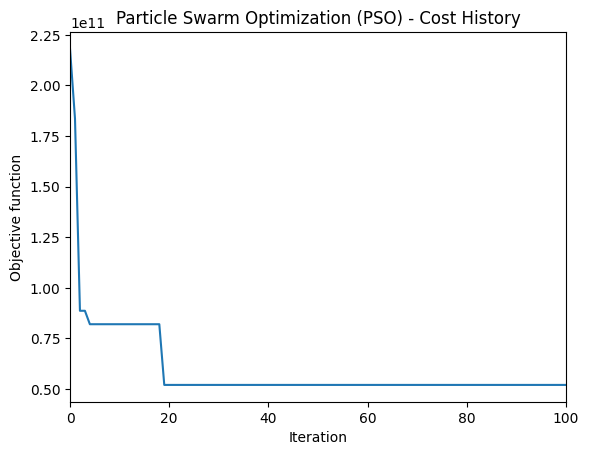

In [268]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, 100)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

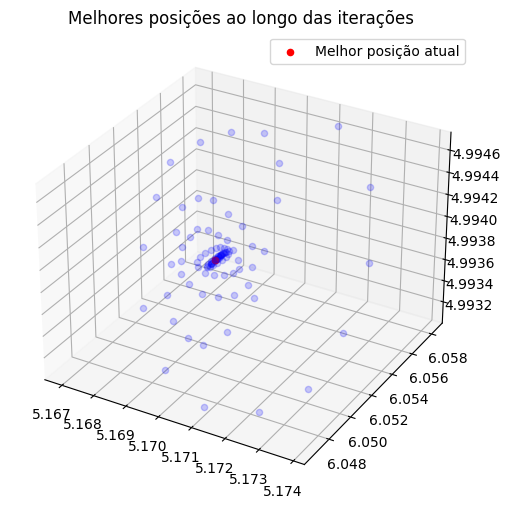

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 156087105113.70334


In [269]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])